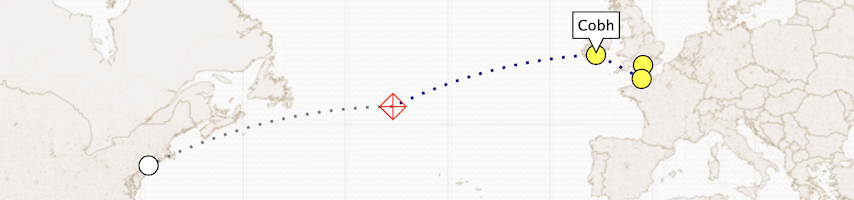

# Visualization of the Titanic's voyage.

In [1]:
import pandas as pd

from lets_plot import *
from lets_plot.geo_data import *

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).


In [2]:
LetsPlot.setup_html()

#### 1. Data Preparation

The Titanic dataset is available at [kaggle](https://www.kaggle.com) : ["Titanic: cleaned data" dataset](https://www.kaggle.com/jamesleslie/titanic-cleaned-data?select=train_clean.csv) (train_clean.csv).

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/titanic.csv")
df.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0


In this Titanic dataset the column `Embarked`contains a single-letter codes of the Titanic's ports of embarkation:
- S: Southampton (UK)
- C: Cherbourg (France)
- Q: Cobh (Ireland)

Let's add new colum "Port" to the data:

In [4]:
def to_port_name (row):
   if row['Embarked'] == 'S' :
      return 'Southampton'
   if row['Embarked'] == 'C' :
      return 'Cherbourg'
   if row['Embarked'] == 'Q' :
      return 'Cobh'
   return 'Other'

df['Port']=df.apply (lambda row: to_port_name(row), axis=1)
df.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size,Port
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1,Southampton
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1,Cherbourg
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0,Southampton


##### 1.1 Travellers Survival Rates by the Port of Embarkation

In [5]:
from lets_plot.mapping import as_discrete

c_surv="#E1A439"
c_lost="#6B9993"

bars = (ggplot(df) +
        geom_bar(
            aes('Port', fill=as_discrete('Survived')), 
            tooltips=layer_tooltips()
                .line('@{..count..} (@{..prop..})')
                .format('@{..prop..}', '.0%'),
            position='dodge') +
        scale_fill_manual(values=[c_lost, c_surv], labels=['no', 'yes']) +
        scale_x_discrete(limits=['Cobh', 'Cherbourg', 'Southampton']) +
        labs(x="", y="Travellers count") + 
        ggtitle("Survival by the Port of Embarkation")
)        

bars + ggsize(800, 300)

#### 2. Ports of Embarkation on Map

Titanic's ports of of embarkation were:
- Southampton (UK)
- Cherbourg (France)
- Cobh (Ireland)

Let's find geographical coordinates of these cities using `Lets-Plot` geocoding module.

In [6]:
from lets_plot.geo_data import *

ports = ['Southampton', 'Cherbourg', 'Cobh']

##### 2.1 Spatial DataFrame (Pandas GeoDataFrame)

In [7]:
ports_gcoder = (geocode_cities(ports)
                .where(ports[0], scope='England')
                .where(ports[1], scope='France'))
ports_gdf = ports_gcoder.get_centroids()
ports_gdf

,city,found name,geometry
0,Southampton,Southampton,POINT (-1.40254 50.91837)
1,Cherbourg,Cherbourg,POINT (-1.60901 49.62728)
2,Cobh,Cobh,POINT (-8.29428 51.85315)


##### 2.2 Markers on Map

`Lets-Plot` API makes it easy to create an interactive basemap layer using either its own vector tiles service or 
by configuring a 3-rd party Z-X-Y raster tile providers.

In this notebook we will use beautifull *CARTO Voyager* raster tiles by [CARTO](https://carto.com/attribution/) as our basemap.

In [8]:
from lets_plot import tilesets

LetsPlot.set(tilesets.CARTO_VOYAGER_HIRES)

In [9]:
basemap = ggplot() + geom_livemap() + ggsize(800, 350)


port_markers = geom_point(
                   map=ports_gdf, 
                   size=7, 
                   shape=21, 
                   color="black", 
                   fill="yellow")

basemap + port_markers

#### 3. The "Titanic's site" Marker

In [10]:
from shapely.geometry import Point, LineString
titanic_site = Point(-38.056641, 46.920255)

titanic_site_marker = geom_point(x=titanic_site.x, y = titanic_site.y, size=10, shape=9, color='red')

basemap + port_markers + titanic_site_marker

#### 4. The New York City Marker

New York City was the Titanic's destination.

In [11]:
NYC = geocode_cities(['New York']).get_centroids().geometry[0]
NYC_marker = geom_point(x=NYC.x, y=NYC.y, size=7, shape=21, color='black', fill='white')

(basemap + 
 port_markers +
 titanic_site_marker +
 NYC_marker
)

#### 5. Connecting Markers on Map

To connect markers on the map we will create a `LineString` object (from `Shaply` package).

In [12]:
from geopandas import GeoSeries
from geopandas import GeoDataFrame

# Points of embarkation (GeoSeries).
port_points = ports_gdf.geometry
path_points = pd.concat([port_points, GeoSeries([titanic_site, NYC], crs=ports_gdf.crs)], ignore_index=True)

# Create a new GeoDataFrame containing a `LineString` geometry.
path_gdf = GeoDataFrame(
    dict(geometry=[ LineString(path_points) ])
)

In [13]:
# Add "path" to the map.
titanic_path = geom_path(
    map=path_gdf, 
    geodesic=True,
    color='dark-blue', 
    linetype='dotted', size=1.2)

(basemap +
 titanic_path +
 port_markers +
 titanic_site_marker +
 NYC_marker
)

#### 6. Pie-chart Markers on Map

##### 6.1 Travellers Survival Rates, Now with Pie

In [14]:
pies = (ggplot(df) +
        geom_pie(
            aes(x='Port', y="..sum..", fill=as_discrete('Survived'), size="..sum.."), 
            labels=layer_labels()
                             .line('@{..count..}')
                             .line('(@{..prop..})').format('@{..prop..}', '.0%'),
            tooltips=layer_tooltips().title("@Port (@{..sum..})"),
            stroke=1.5, 
            hole=0.5) +
        scale_fill_manual(values=[c_lost, c_surv], labels=['no', 'yes']) +
        scale_x_discrete(limits=['Cobh', 'Cherbourg', 'Southampton'], expand=[0, 0.3]) +
        scale_size(range=[3, 10], guide="none") +
        ylim(0, 800) +
        labs(x="", y="Travellers count") + 
        ggtitle("Survival by the Port of Embarkation")
)

pies + ggsize(800, 300)

##### 6.2 Spatial Pies

In [15]:
spatial_pies = (
        geom_pie(
            aes(x='Port', fill=as_discrete('Survived'), size="..sum.."), 
            data=df,
            map=ports_gdf, 
            map_join=['Port','city'],
            tooltips = layer_tooltips()
                    .title("@Port (@{..sum..})")
                    .line('@{..count..} (@{..prop..})')
                    .format('@{..prop..}', '.0%'),
            stroke = 1.5, 
            hole = 0.5) +
        scale_fill_manual(values=[c_lost, c_surv], labels=['lost', 'survived']) +
        scale_size(range=[3, 10], guide="none") +
        theme(legend_position=[0.5, 1], 
              legend_justification=[0.5, 1], 
              legend_direction='horizontal',
              legend_title=element_blank())
)                


(basemap + 
 titanic_path +
 spatial_pies +
 titanic_site_marker +
 NYC_marker
)

##### 6.3 Adjusting the Map Zoom Level and Position

In [16]:
(ggplot() + ggsize(900, 600) + ggtitle("Titanic Survival Rate by Port of Embarkation") +
     geom_livemap(zoom=6, location=[-8.29, 51.85, -1.61, 49.63]) + 
     titanic_path +
     port_markers +
     spatial_pies +
     titanic_site_marker +
     NYC_marker +
     theme(text=element_text(family="Garamond"),
           plot_title=element_text(size=30))
) 